In [11]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from numpy import trapz

Generate Data ⬇️

In [12]:
def getbJetTrack(mu = 0, sig = 0.5, decay=3, fracDecay=0.05, fracFlat=0.05):
    r = np.random.rand()
    if (r < fracDecay):
        return np.random.exponential(decay)+np.random.normal(0,0.25)
    elif (r < (fracDecay+fracFlat)):
        return 6 * np.random.random_sample()-3 #get flat -3 to 2
    else:
        return np.random.normal(mu,sig) 

def getLFTrack(mu = 0, sig = 0.5, fracFlat=0.05):
    r = np.random.rand()
    if( r < fracFlat):
        return 6 * np.random.random_sample()-3
    else:        
        return np.random.normal(mu,sig)

def getbJetData(NumData, fracDecay=0.05): #get list of NumData number of elements. 
    DataSet=[]
    for i in range (NumData):
        n = np.random.poisson(4)
        tracks=[]
        for j in range (n):
            tracks.append(getbJetTrack(fracDecay=fracDecay))
        DataSet.append(tracks)
    return DataSet

def getLFJetData(NumData): # get list of NumData number of elements
    DataSet=[]
    for i in range (NumData):
        n = np.random.poisson(2)
        tracks=[]
        for j in range (n):
            tracks.append(getLFTrack())
        DataSet.append(tracks)
    return DataSet

KNN ⬇️

In [13]:
def DataSameLen(listOfLists): # add 0 to the end of stort list elements
    maxLen=0
    for i in listOfLists:
        if len(i)>maxLen:
            maxLen=len(i)
    for i in listOfLists:
        if len(i)<maxLen:
            while(len(i)<maxLen):
                i.append(0)
    return listOfLists

def getData(NumData): #combines B jet data and LF jet data, NumData: number of data in each, adds indicator at the front
    bj=getbJetData(NumData) #only train uses this
    j=0
    for i in bj:
        bj[j] = [True] + i
        j+=1
    lfj=getLFJetData(NumData)
    k=0
    for i in lfj:
        lfj[k] = [False] + i
        k+=1
    for j in lfj:
        bj.append(j)
    return bj

def dist(elem_train, elem_test): 
    d=0.0
    for i in range(1, len(elem_train)):
        d+=(elem_train[i]-elem_test[i-1])**2
    return np.sqrt(d)

def getNbors(train, elem_test, k):
    distance=[]
    for elem in train:
        distance.append([elem,dist(elem,elem_test)])
    distance.sort(key = lambda ls : ls[1])
    nbors=[]
    for i in range(k):
        nbors.append(distance[i][0])
    return nbors

def BjetProb(train, elem_test, k):
    neigbors=getNbors(train,elem_test,k)
    numTrue=0
    for i in neigbors:
        if (i[0]==True):
            numTrue+=1
    return float(numTrue)/float(len(neigbors))

# Plot the Data

In [14]:
def flatten(inData): 
    dataFlat = np.array([])
    for jet in inData:
        dataFlat = np.append(dataFlat,jet)
    return dataFlat

11


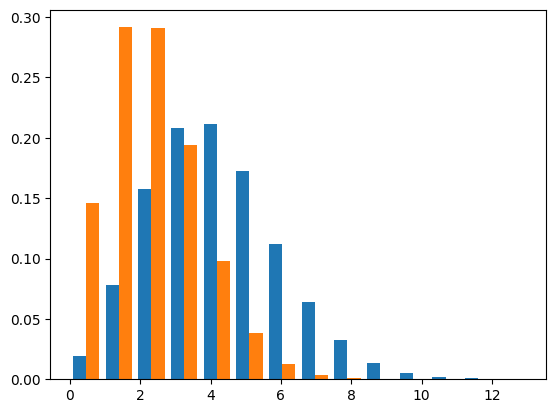

In [15]:
nEvents = 100000

bj=getbJetData(nEvents, fracDecay=0.2) #only train uses this
lf=getLFJetData(nEvents)

length_b = []
for i in bj:
    length_b.append(len(i))
length_lf = []
for i in lf:
    length_lf.append(len(i))
# this is for poisson likelihood
print(max(length_lf))
lenCount, lenBins, lenPatch=plt.hist([length_b,length_lf],bins=np.linspace(0,13,15), density=True)

In [16]:
bjFlat = flatten(bj)

lfFlat = flatten(lf)

print(f"{len(bjFlat)} vs {len(lfFlat)}")

400700 vs 199881


[[0.00919137 0.00717375 0.00851883 0.00896719 0.00851883 0.00919137
  0.00851883 0.01031227 0.00851883 0.01053645 0.00694957 0.01120899
  0.01008809 0.00874301 0.00784629 0.00829465 0.01008809 0.00986391
  0.00986391 0.00963973 0.00739793 0.00963973 0.01165735 0.00784629
  0.00829465 0.01076063 0.01008809 0.00986391 0.00739793 0.01076063
  0.00784629 0.00717375 0.00717375 0.00650121 0.00896719 0.01300243
  0.00739793 0.00851883 0.01098481 0.00829465 0.00874301 0.00851883
  0.00762211 0.00851883 0.00829465 0.00762211 0.00941555 0.00963973
  0.00829465 0.00829465 0.01143317 0.00919137 0.00896719 0.01120899
  0.00784629 0.00986391 0.00807047 0.00986391 0.01053645 0.00672539
  0.00807047 0.00784629 0.00941555 0.00963973 0.00762211 0.00717375
  0.01210571 0.01277825 0.01076063 0.00941555 0.00784629 0.00784629
  0.00896719 0.00941555 0.00874301 0.00896719 0.00963973 0.00807047
  0.00627703 0.01165735 0.00941555 0.01031227 0.00829465 0.00807047
  0.01188153 0.00784629 0.00807047 0.00739793 0.

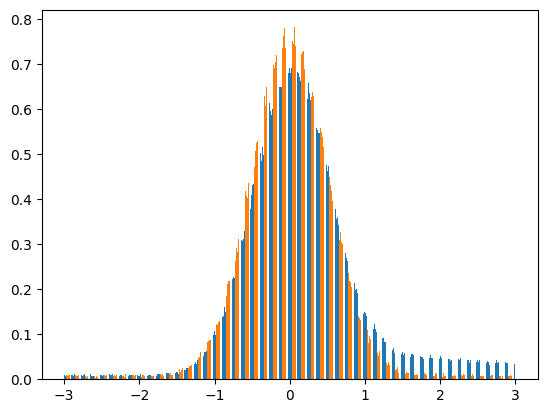

In [17]:
bins = np.linspace(-3,3,500)
#c1, b1, p1 = plt.hist(bjFlat,bins=bins,density=True)
#c2, b2, p2 = plt.hist(lfFlat,bins=bins,histtype="step", density=True)
TrainHistCounts, TrainHistBins, patch = plt.hist([bjFlat,lfFlat],bins=bins,density=True)
#plt.yscale("log")
print(TrainHistCounts)
plt.show()

plot ROC

In [28]:
def pltROCnAUC(counts, bins, label): 
    x=[]
    y=[]
    for i in range(len(counts[0])):
        p = 0
        n = 0
        for j in range(i,len(counts[0])):
            p = p + counts[0][j]*(bins[j+1]-bins[j])
            n = n + counts[1][j]*(bins[j+1]-bins[j])
        x.append(p)
        y.append(n)
    AUC=trapz(x,y)
    plt.plot(y,x,label=label)
    plt.legend()
    return AUC

In [19]:
#getting data
n=1000
train = getData(n)
bj_test=getbJetData(n,fracDecay=0.2)
lf_test=getLFJetData(n)

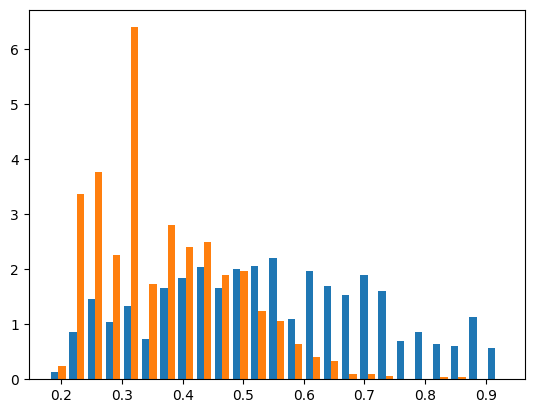

In [20]:
#KNN
train1=copy.deepcopy(train)
DataSameLen(train1)
bj_test1 = copy.deepcopy(bj_test)
DataSameLen(bj_test1)
lf_test1 = copy.deepcopy(lf_test)
DataSameLen(lf_test1)

if (len(bj_test1[0])<len(train1[0])-1):
    for i in bj_test1:
        while(len(i)<len(train1[0])-1):
            i.append(0)
if (len(lf_test1[0])<len(train1[0])-1):
    for i in lf_test1:
        while(len(i)<len(train1[0])-1):
            i.append(0)

b_prob=[]
lf_prob=[]
for i in bj_test1:
    b_prob.append(BjetProb(train1,i,100))
for i in lf_test1:
    lf_prob.append(BjetProb(train1,i,100))
counts, bins, patches= plt.hist([b_prob,lf_prob], bins=25, density=True)

In [21]:
def trim(floatListList, N):
    res=[]
    falseNum=0
    for i in floatListList:
        if len(i)<N:
            floatListList.remove(i)
            falseNum=falseNum+1
        else:
            mx=[]
            for j in range(N):
                mx.append(np.max(i))
                i.remove(np.max(i))
            res.append(mx)
    return res, falseNum  

def trimTrain(floatListList, N):
    res=[]
    for i in floatListList:
        ind = i[0]
        i.pop(0)
        if len(i)<N:
            floatListList.remove(i)
        else:
            mx=[]
            mx.append(ind)
            for j in range(N):
                mx.append(np.max(i))
                i.remove(np.max(i))
            res.append(mx)
    return res       

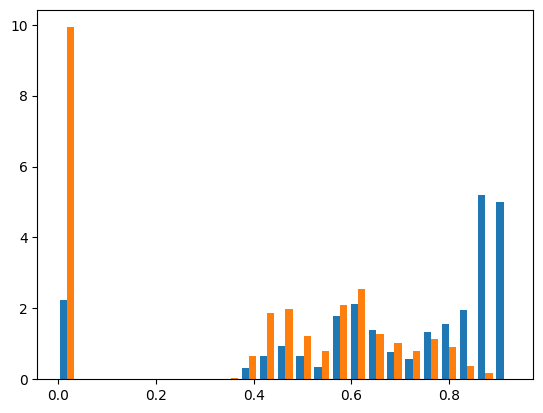

In [22]:
#2d-KNN
train2=copy.deepcopy(train)
train2=trimTrain(train2,2)

bj_test2=copy.deepcopy(bj_test)
lf_test2=copy.deepcopy(lf_test)
bj_test2, bj_fn = trim(bj_test2,2)
lf_test2, lf_fn = trim(lf_test2,2)

b_prob2=[]
lf_prob2=[]
for i in bj_test2:
    b_prob2.append(BjetProb(train2,i,100))
for i in range(bj_fn):
    b_prob2.append(0)
for i in lf_test2:
    lf_prob2.append(BjetProb(train2,i,100))
for i in range(lf_fn):
    lf_prob2.append(0)
counts2, bins2, patches2 = plt.hist([b_prob2,lf_prob2], bins=25, density=True)

[[0.3453353038139811, [-0.5321904570195404, -0.25965902061262136, -0.5899654585399539, 0.07826906211917849, -0.2130596729111034, -0.48593987170776015, -1.0654628369947743]], [0.3843364096609137, [-0.7210789597236043, 0.034046400404219905, -0.42403771707818233, -0.20106507596086717, -0.5724578254330965, -0.16165451530679675, -0.5912491323417247]], [0.39813138508100515, [-0.5142770092342206, -0.18504395749752198, 0.524506087827105, 0.2375130674823564, 0.4488354698342973, -0.4267205036182473, -0.8187619780208016, -0.28843288949389523]], [0.3988211101277727, [-0.15897947938807444, -0.2536664609232272, -0.4260607799773889, -0.9389453324756236, -0.22743080212176245, 0.07421124235216967, 0.12280732954411591, 0.006317425654967072, 0.38798051013529883]], [0.40548103673984665, [0.4525386634892921, -0.046109860722252954, -0.2851130656708035, -0.43111622048356707, -0.245529758185409, -0.4326069246211896, -0.11191463473112065]], [0.40795157817844985, [0.15850610572941815, 0.22921667568888354, -0.39

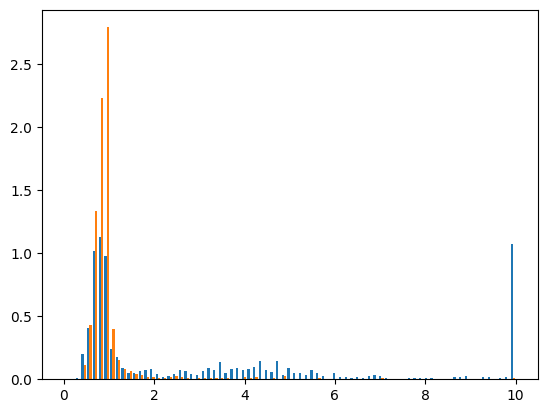

In [23]:
#likelyhood #This uses the histogram for d0
def probInHist(d0, counts, bins): #counts is list of lists
    x=len(bins)-2
    for i in range(len(bins)): 
        if d0 < bins[i]:
            x=i-1
            break
    p=(counts[0][x])/(counts[1][x])
    return p

def likelihood(test, train_hist_counts, train_hist_bins):
    p=[]
    for i in test:
        pi=1
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append(pi) 
    return p

def llhANDjets(test, train_hist_counts, train_hist_bins):
    p=[]
    for i in test:
        pi=1
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append([pi,i]) ###############just to see the jets and its likelihood
    return p

bj_test3=copy.deepcopy(bj_test)
lf_test3=copy.deepcopy(lf_test)

bj_p3=likelihood(bj_test3,TrainHistCounts,TrainHistBins)
lf_p3=likelihood(lf_test3,TrainHistCounts,TrainHistBins)

for i in range(len(bj_p3)):
    if bj_p3[i] > 10:
        bj_p3[i] = 10

for i in range(len(lf_p3)):
    if lf_p3[i] > 10:
        lf_p3[i] = 10

bj_p3_ = llhANDjets(copy.deepcopy(bj_test3),TrainHistCounts,TrainHistBins)
lf_p3_ =llhANDjets(copy.deepcopy(lf_test3),TrainHistCounts,TrainHistBins)

bj_p3_.sort(key = lambda ls : ls[0])
lf_p3_.sort(key = lambda ls : ls[0])

print(bj_p3_)
print(lf_p3_)
counts3, bins3, patches3 = plt.hist([bj_p3,lf_p3], bins=np.linspace(0,10,80), density=True)

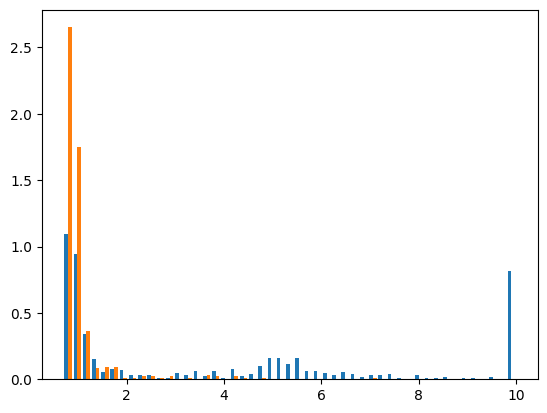

In [24]:
# 2d likelihoood
bj_test5=copy.deepcopy(bj_test2)
lf_test5=copy.deepcopy(lf_test2)

bj_p5=likelihood(bj_test5,TrainHistCounts,TrainHistBins)
lf_p5=likelihood(lf_test5,TrainHistCounts,TrainHistBins)

for i in range(bj_fn):
    bj_p5.append(min(bj_p5))
for i in range(bj_fn):
    lf_p5.append(min(lf_p5))

for i in range(len(bj_p5)):
    if bj_p5[i] > 10:
        bj_p5[i] = 10

for i in range(len(lf_p5)):
    if lf_p5[i] > 10:
        lf_p5[i] = 10

counts5, bins5, patches5 = plt.hist([bj_p5,lf_p5], bins=np.linspace(0.7,10,50), density=True)

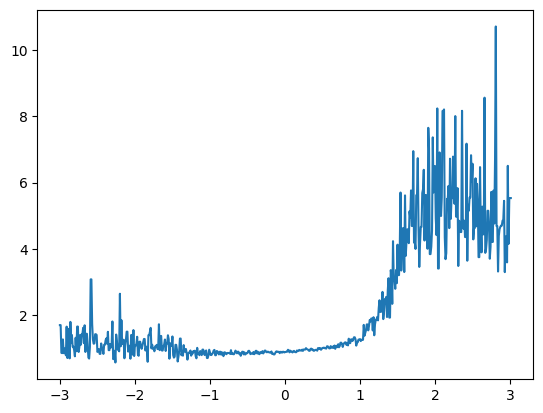

In [25]:
j=-3
list=[]
list.append(j)
while j<=3:
    j+=0.01
    list.append(j)

list2=[]
for d0 in list:
    k=probInHist(d0,TrainHistCounts,TrainHistBins)
    list2.append(k)

plt.plot(list,list2)

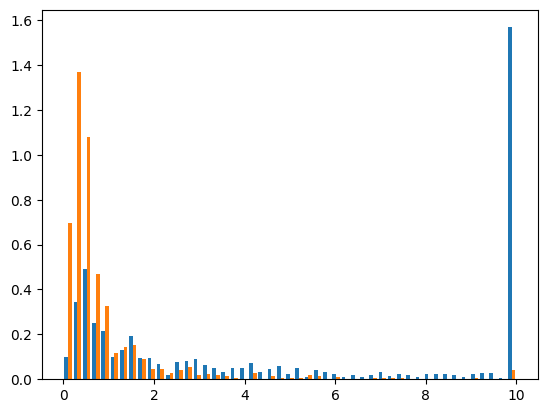

In [26]:
#POISSSON likelyhood
def Poissonlikelihood(test, train_hist_counts, train_hist_bins):
    p=[]
    for i in test:
        pi=probInHist(len(i),lenCount,lenBins)
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append(pi)
    return p

bj_test4=copy.deepcopy(bj_test) 
lf_test4=copy.deepcopy(lf_test)

bj_p4=Poissonlikelihood(bj_test4,TrainHistCounts,TrainHistBins)
lf_p4=Poissonlikelihood(lf_test4,TrainHistCounts,TrainHistBins)

for i in range(len(bj_p4)):
    if bj_p4[i] > 10:
        bj_p4[i] = 10

for i in range(len(lf_p4)):
    if lf_p4[i] > 10:
        lf_p4[i] = 10
        
counts4, bins4, patches4 = plt.hist([bj_p4,lf_p4], bins=np.linspace(0,10,50), density=True)


AUC of knn: 0.7844790000000001
AUC of 2d knn: 0.8094582437273332
AUC of likelihood: 0.6798640000000004
AUC of poisson likelihood: 0.8303210000000004
AUC of 2d likelihood: 0.7700412409810118


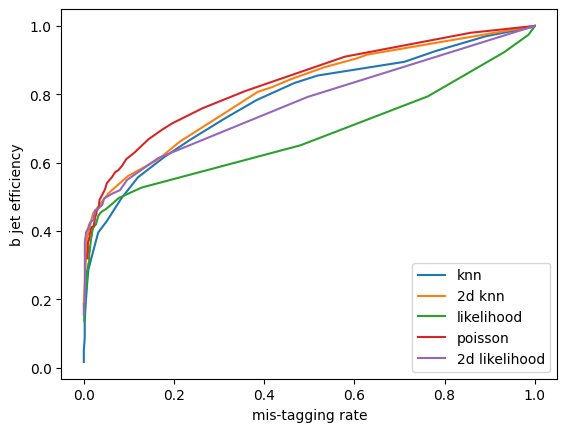

In [31]:
area1 = pltROCnAUC(counts, bins, "knn")
area2 = pltROCnAUC(counts2, bins2, "2d knn")
area3 = pltROCnAUC(counts3, bins3, "likelihood")
area4 = pltROCnAUC(counts4, bins4, "poisson")
area5 = pltROCnAUC(counts5, bins5, "2d likelihood")

plt.ylabel("b jet efficiency")
plt.xlabel("mis-tagging rate")
print("AUC of knn:",-area1)
print("AUC of 2d knn:",-area2)
print("AUC of likelihood:",-area3)
print("AUC of poisson likelihood:",-area4)
print("AUC of 2d likelihood:",-area5)